In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import math
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
from tqdm import tqdm_notebook
from sklearn.cluster import DBSCAN
from tqdm import notebook
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transform
from torchvision.io import read_image
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/기말과제111/archive.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: masks/masks/ID00290637202279304677843_mask_155.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_156.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_157.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_158.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_159.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_16.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_160.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_161.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_162.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_163.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_164.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_165.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_166.jpg  
  inflating: masks/masks/ID00290637202279304677843_mask_167.jpg  
  inflating: masks/masks/ID00290637202279

In [4]:
import pandas as pd

In [5]:
data_read = pd.read_csv('/content/train.csv')
train_ID = data_read['ImageId'].tolist()
mask_ID = data_read['MaskId'].tolist()

In [6]:
class Potdataset(Dataset):
    def __init__(self, data_dir, masked_dir, transform = True, IMAGE_SIZE = 224, phase = 'train'):
        
        self.data_dir = data_dir
        self.masked_dir = masked_dir
        if phase == 'train':
          self.data_names = train_ID[:13000]
          self.masked_names = mask_ID[:13000]
        else:
          self.data_names = train_ID[13000:]
          self.masked_names = mask_ID[13000:]

        
        self.dataset_size = len(self.data_names)
        self.IMAGE_SIZE = IMAGE_SIZE
        self.transform = transform
        assert len(self.data_names) ==len(self.masked_names)
        
        
    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.data_dir+ '/images/' + self.data_names[idx]))
        image = cv2.resize(image, dsize = (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)

        mask = cv2.imread(os.path.join(self.masked_dir+ '/masks/' + self.masked_names[idx]))
        mask = cv2.resize(mask, dsize = (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation = cv2.INTER_NEAREST)
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255

        mask_H, mask_W, mask_C = mask.shape
        background= np.ones(shape = (mask_H, mask_W))
        background[mask[..., 0] != 0] = 0
        background[mask[..., 1] != 0] = 0
        background[mask[..., 2] != 0] = 0
        mask = np.concatenate([np.expand_dims(background, axis = -1), mask], axis= -1)
        mask= np.argmax(mask, axis = -1)
      
        if self.transform:
          image = self.transform(image)
        target = torch.from_numpy(mask).long()
        return image, target


In [7]:
transform_image = transform.Compose([transform.ToTensor(),
                                      transform.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])])

In [8]:
data_dir = '/content/images'
label_dir = '/content/masks'

train_set = Potdataset(data_dir, label_dir, transform = transform_image, phase = 'train')
validation_set = Potdataset(data_dir, label_dir, transform = transform_image, phase = 'validation')

In [9]:
image, target = train_set[12999]

In [10]:
print(f'이미지의 크기: {image.shape}, 라벨의 크기: {target.shape}')

이미지의 크기: torch.Size([3, 224, 224]), 라벨의 크기: torch.Size([224, 224])


이미지는 [채널수, 행 크기, 열 크기]로 구성, 라벨은 [행의 크기, 열의 크기]
로 구성되어 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


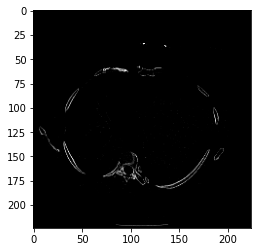

In [11]:
plt.imshow(image.permute(1, 2, 0))

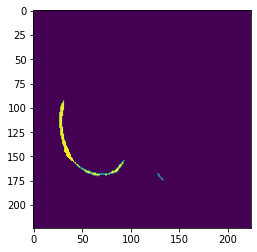

In [12]:
plt.imshow(target)

#배치형태로 이미지가 구성이 될때 배치를 어떻게 구성할 것이냐? 이미지, 라벨, maskdataset을 어떻게 미니배치 형태로 구성을 할 것인지 collate_function을 통해 dataloader을 통해 전달  

입력사진: [배치사이즈, 채널, 행 크기, 열 크기]  
라벨: [배치사이즈, 행 크기, 열 크기]

In [11]:
def collate_fn(batch):  
  images = []
  targets = []
  for a, b in batch:
    images.append(a)
    targets.append(b)
  
  images = torch.stack(images, dim = 0)
  targets = torch.stack(targets, dim = 0)
  return images, targets

In [12]:
def build_dataloader(train_set, validation_set, batch_size = 4):
  dataloaders = {}
  dataloaders['train'] = DataLoader(train_set, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)
  dataloaders['validation'] = DataLoader(validation_set, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)
  return dataloaders


In [13]:
dataloaders = build_dataloader(train_set, validation_set, batch_size = 16)

In [16]:
for phase in ['train', 'validation']:
  for i, batch in enumerate(dataloaders[phase]):
    images, targets = batch
    print(f"===={phase}====")
    print("이미지 크기:", images.size())
    print("라벨 크기:", targets.size())
  

    if i == 0:
      break
    
    
    


====train====
이미지 크기: torch.Size([16, 3, 224, 224])
라벨 크기: torch.Size([16, 224, 224])
====validation====
이미지 크기: torch.Size([16, 3, 224, 224])
라벨 크기: torch.Size([16, 224, 224])


dataloader을 훈련과 검증에 따른 수행을 다르게 하기 위해, key와 value를 가진 딕셔너리로 정의하였다. 

#모델 정의하기

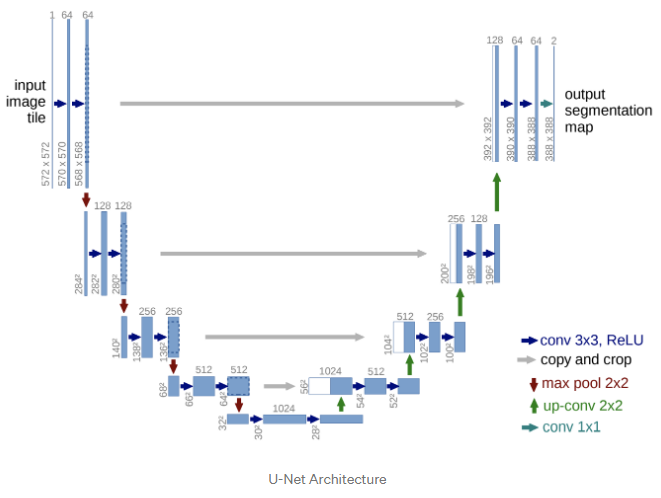

Encoder-Decoder구조로 이루어진 Unet을 구현하려고 한다.  
- Encoder: Encoder로 이미지에서 유의미한 feature map을 형성합니다.
- Decoder: 입력이미지에 해당하는 semantic한 정보를 upsampling하면서 segmentation결과를 만듭니다. 


up conv: 원본이미지에서 기본 컨볼루션(곱 연산 누적 합)하면 컨볼루션을 한 결과값과 컨볼루션 필터 값을 가지고 역행렬을 구합니다. 

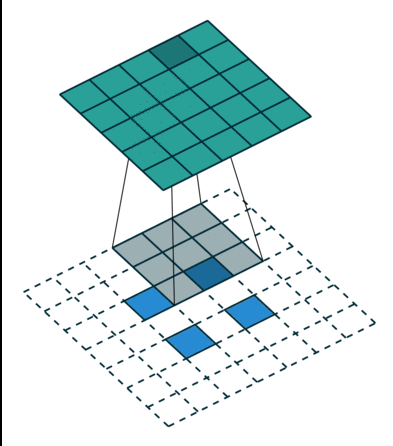

skip connection: encoder에서 layer을 통과하면서 객체 정보는 많아지지만,     
resolution은 줄어듭니다. 이 상태로 up convolution을 하면, 원본 이미지 자세한   부분을 놓지게 됩니다.  
 모서리와 target과 차이를 최소화하기 위해 사용됩니다.

In [14]:
def Convlayer(in_channels, out_channels):
  layers = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True),

      nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True)
  )
  return layers

In [15]:
class Encoder(nn.Module):
  def __init__(self,):
    super().__init__()
    self.conv_block1 = Convlayer(in_channels = 3, out_channels = 32)
    self.conv_block2 = Convlayer(in_channels = 32, out_channels = 64)
    self.conv_block3 = Convlayer(in_channels = 64, out_channels = 128)
    self.conv_block4 = Convlayer(in_channels = 128, out_channels = 256)
    self.conv_block5 = Convlayer(in_channels = 256, out_channels = 512)
    self.pool = nn.MaxPool2d(kernel_size = 2)

  def forward(self, x):
    encode_features = []

    out = self.conv_block1(x)
    encode_features.append(out)
    out = self.pool(out)
  
    
    out = self.conv_block2(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block3(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block4(out)
    encode_features.append(out)
    out = self.pool(out)
    
  

    out = self.conv_block5(out)

    return out, encode_features

    



In [16]:
encoder1 = Encoder()
x = torch.randn(1, 3, 256, 256)

In [17]:
def UpConvLayer(in_channels, out_channels):
  layers = nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True)
  )
  return layers


In [18]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.upconv_layer1 = UpConvLayer(in_channels = 512, out_channels = 256)
    self.conv_block1 =  Convlayer(in_channels = 512, out_channels = 256)
    
    self.upconv_layer2 = UpConvLayer(in_channels = 256, out_channels = 128)
    self.conv_block2 =  Convlayer(in_channels = 256, out_channels = 128)

    self.upconv_layer3 = UpConvLayer(in_channels = 128, out_channels = 64)
    self.conv_block3 =  Convlayer(in_channels = 128, out_channels = 64)

    self.upconv_layer4 = UpConvLayer(in_channels = 64, out_channels = 32)
    self.conv_block4 =  Convlayer(in_channels = 64, out_channels = 32)
    

  def forward(self, x, encoder_features):
    out = self.upconv_layer1(x)
    out = torch.cat([out, encoder_features[-1]], dim = 1)
    out = self.conv_block1(out)

    out = self.upconv_layer2(out)
    out = torch.cat([out, encoder_features[-2]], dim = 1)
    out = self.conv_block2(out)

    out = self.upconv_layer3(out)
    out = torch.cat([out, encoder_features[-3]], dim = 1)
    out = self.conv_block3(out)
    
    out = self.upconv_layer4(out)
    out = torch.cat([out, encoder_features[-4]], dim = 1)
    out = self.conv_block4(out)

  

    return out
    


In [19]:
decoder1 = Decoder()
encoder1 = Encoder()

In [23]:
x = torch.randn(1, 3, 224, 224)

In [24]:
out, encode = encoder1(x)

In [25]:
encode[1].shape

torch.Size([1, 64, 112, 112])

In [26]:
ss = decoder1(out, encode)
ss.shape

torch.Size([1, 32, 224, 224])

In [27]:
class Unet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.head= nn.Conv2d(32, num_classes, kernel_size = 1, padding = 0)
  
  def forward(self, x):
    out, encode_features = self.encoder(x)
    out = self.decoder(out, encode_features)
    out = self.head(out)
    return out

In [28]:
NUM_CLASSES = 4
model = Unet(NUM_CLASSES)

In [29]:
print(model)

Unet(
  (encoder): Encoder(
    (conv_block1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (conv_block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (conv_block3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

#평가지표 정의하기

Dice similarity coefficient

Dice: (2 x (A*B) / (A + B))

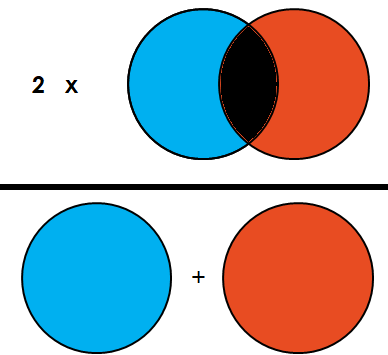

Segmentation에서 F1 score과 비슷하다.   
F1 score이란 precision(정확도)과 recall(재현율)을 고려한  
성능지표이다.

1-dsc를 하면? dsc loss가 나온다.

In [20]:
class Unet_metric():
  def __init__(self, num_classes):
    self.num_classes = num_classes
    self.CE_loss = nn.CrossEntropyLoss(reduction = "mean") #detection, segmentation은 여러개의 element가 존재
    #2, 3차원이라서 mean을 사용

  def __call__(self, pred, target):
    onehot_pred = F.one_hot(torch.argmax(pred, dim = 1), num_classes = self.num_classes).permute(0, 3, 1, 2)
    onehot_target = F.one_hot(target, num_classes = self.num_classes).permute(0, 3, 1, 2)
    dice_coefficient = self.get_batch_dice_coefficient(onehot_pred, onehot_target)
    loss1 = self.get_dice_loss(onehot_pred, onehot_target)
    loss2 = self.CE_loss(pred, target)
    loss = loss1 + loss2
    return loss, dice_coefficient
  

  def get_dice_coefficient(self,  pred, target):
    dice = 0
    for class_idx in range(1, self.num_classes):
      A = pred[class_idx]
      B = target[class_idx]
      set_inter = torch.dot(A.reshape(-1).float(), B.reshape(-1).float())
      set_sum = A.sum() + B.sum()
      if set_sum.item()== 0:
        set_sum = 2 * set_inter
      dice += ((2 * set_inter) / (set_sum + 1e-8))
    dice /= (self.num_classes - 1)
    return dice

  def get_batch_dice_coefficient(self, pred, target):
    num_batch = pred.shape[0]
    dice = 0
    for batch_idx in range(num_batch):
      dice += self.get_dice_coefficient(pred[batch_idx], target[batch_idx])
    return dice / num_batch

  def get_dice_loss(self, pred, target):
    return 1. - self.get_batch_dice_coefficient(pred, target)


In [22]:
NUM_CLASSES = 4
criterion = Unet_metric(num_classes = NUM_CLASSES)

In [32]:
for i, data in enumerate(dataloaders['train']):
  images, labels = data
  predictions = model(images)
  loss, asc = criterion(predictions, labels)
  print(loss, asc)



  if i== 0:
    break

tensor(2.6157, grad_fn=<AddBackward0>) tensor(0.0205)


Loss function 구현, SGDM최적화사용

2개의 loss사용   
dice loss와 cross entropy loss를 사용

In [ ]:
loss.backward()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
optimizer.step()

#학습과정

In [23]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
  losses = {}
  dice_coefficients = {}
  
  for phase in ["train", "validation"]:
    running_loss = 0.0
    running_dice_coeff = 0.0

    if phase == "train":
      model.train()

    else:
      model.eval()

    for idx, data in enumerate(dataloaders[phase]):
      images = data[0].to(DEVICE)
      labels = data[1].to(DEVICE)
      with torch.set_grad_enabled(phase == "train"):
        predictions = model(images)
        loss, dice_coefficient = criterion(predictions, labels)

        if phase == "train":
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
        running_loss += loss.item()
        running_dice_coeff += dice_coefficient.item()

        if phase == "train":
          if idx > 0 and idx % 100 == 0:
            text = f"{idx}/{len(dataloaders['train'])}" +\
            f"-Running loss: {loss.item():.4f}" + \
            f"-Running dice: {dice_coefficient.item():4f}"
            print(text)

    losses[phase] = running_loss / len(dataloaders[phase])
    dice_coefficients[phase] = running_dice_coeff / len(dataloaders[phase])
  return losses, dice_coefficients

        

    

In [34]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fadd00a3410>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7fadd00a9690>}

In [35]:
NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE= 16
is_cuda = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
print(DEVICE)
model = Unet(num_classes = NUM_CLASSES)
model = model.to(DEVICE)
criterion = Unet_metric(num_classes = NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

cuda


In [36]:
num_epochs = 15
best_epoch = 0
best_score = 0.0
train_loss, train_dice_coeff = [], []
val_loss, val_dice_coeff = [], []
for epoch in range(num_epochs):
  losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
  train_loss.append(losses["train"])
  val_loss.append(losses["validation"])
  train_dice_coeff.append(dice_coefficients["train"])
  val_dice_coeff.append(dice_coefficients["validation"])

  print(f"{epoch} / {num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['validation']:.4f}")
  print(f"{epoch} / {num_epochs} - Train{dice_coefficients['train']:.4f}, Val: {dice_coefficients['validation']:.4f}")

  

100/813-Running loss: 1.1932-Running dice: 0.000000
200/813-Running loss: 1.7738-Running dice: 0.000000
300/813-Running loss: 1.7638-Running dice: 0.000000
400/813-Running loss: 1.1543-Running dice: 0.000000
500/813-Running loss: 1.0037-Running dice: 0.263335
600/813-Running loss: 0.8967-Running dice: 0.297604
700/813-Running loss: 0.8738-Running dice: 0.304094
800/813-Running loss: 0.9207-Running dice: 0.307303
0 / 15 - Train loss: 1.2202, Val loss: 1.2823
0 / 15 - Train0.0861, Val: 0.0517
100/813-Running loss: 1.0487-Running dice: 0.000000
200/813-Running loss: 1.0922-Running dice: 0.321981
300/813-Running loss: 1.3950-Running dice: 0.229625
400/813-Running loss: 0.9248-Running dice: 0.137872
500/813-Running loss: 0.8272-Running dice: 0.313957
600/813-Running loss: 0.7571-Running dice: 0.327051
700/813-Running loss: 0.7680-Running dice: 0.325082
800/813-Running loss: 0.8837-Running dice: 0.307111
1 / 15 - Train loss: 0.9624, Val loss: 1.0255
1 / 15 - Train0.1876, Val: 0.1745
100/813-

In [43]:
num_epochs = 15
best_epoch = 0
best_score = 0.0

for epoch in range(num_epochs):
  losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
  train_loss.append(losses["train"])
  val_loss.append(losses["validation"])
  train_dice_coeff.append(dice_coefficients["train"])
  val_dice_coeff.append(dice_coefficients["validation"])

  print(f"{16+epoch} / {30} - Train loss: {losses['train']:.4f}, Val loss: {losses['validation']:.4f}")
  print(f"{16+epoch} / {30} - Train{dice_coefficients['train']:.4f}, Val: {dice_coefficients['validation']:.4f}")

100/813-Running loss: 1.0203-Running dice: 0.000000
200/813-Running loss: 0.4046-Running dice: 0.644966
300/813-Running loss: 0.5079-Running dice: 0.597035
400/813-Running loss: 0.8689-Running dice: 0.148749
500/813-Running loss: 0.7345-Running dice: 0.338496
600/813-Running loss: 0.6911-Running dice: 0.330556
700/813-Running loss: 0.6828-Running dice: 0.363508
800/813-Running loss: 0.5081-Running dice: 0.530489
16 / 30 - Train loss: 0.7889, Val loss: 1.0149
16 / 30 - Train0.2627, Val: 0.2016
100/813-Running loss: 1.0169-Running dice: 0.000000
200/813-Running loss: 0.4098-Running dice: 0.640314
300/813-Running loss: 0.4922-Running dice: 0.602727
400/813-Running loss: 0.8301-Running dice: 0.181730
500/813-Running loss: 0.7298-Running dice: 0.338716
600/813-Running loss: 0.6899-Running dice: 0.330568
700/813-Running loss: 0.6151-Running dice: 0.417984
800/813-Running loss: 0.5189-Running dice: 0.525632
17 / 30 - Train loss: 0.7803, Val loss: 1.0318
17 / 30 - Train0.2665, Val: 0.1943
100/

In [ ]:
#30 epoch 2시간 35분
train_loss.pop(0)
train_dice_coeff.pop(0)
val_loss.pop(0)
val_dice_coeff.pop(0)

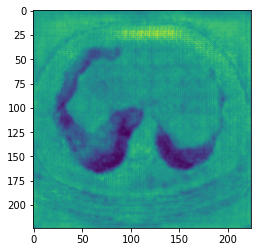

In [38]:
model.to(DEVICE)
for i, data in enumerate(dataloaders['train']):
  images, labels = data
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)
  predictions = model(images)
  plt.imshow(predictions[0][0].detach().cpu().numpy())



  if i== 20:
    break

In [32]:
epoch = []

In [33]:
epoch = np.arange(30)
import csv
def save_result(epoch_, train_loss_, train_accuracy_, val_loss_, val_accuracy_, file_name):
  epoch_ = np.array(['epoch'] + list(epoch_))
  train_loss_ = np.array(['train_loss'] + list(train_loss_)) 
  train_accuracy_ = np.array(['train_accuracy'] + list(train_accuracy_))
  val_loss_ = np.array(['val_loss'] + list(val_loss_))
  val_accuracy_ = np.array(['val_accuracy']+ list(val_accuracy_))
  with open(file_name, 'w') as file:     #"model0.csv"
    writer = csv.writer(file)
    for i in range(len(epoch_)): 
      writer.writerow([epoch_[i], train_loss_[i],train_accuracy_[i],
                   val_loss_[i], val_accuracy_[i]])

In [46]:
save_result(epoch, train_loss, train_dice_coeff, val_loss, val_dice_coeff, "Model1.csv")

In [ ]:
class channel_attention(nn.Module):
  def __init__(self, in_channels, r = 16):
    super().__init__()
    self.avg = nn.AdaptiveAvgPool2d((1,1))
    self.excitation = nn.Sequential(
        nn.Linear(in_channels, r),
        nn.ReLU(),
        nn.Linear(r, in_channels),
        nn.Sigmoid()
        )
    
  def forward(self, input):
    x = self.avg(input) #x.size([batch_size, channel_size, 1, 1])
    x = x.view(x.size(0), -1) #x.size([batch_size, channel_size])
    x = self.excitation(x)
    x = x.view(x.size(0), x.size(1), 1, 1)
    return torch.mul(x, input)

In [24]:
class spatial_attention(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.spatial = nn.Conv2d(in_channels, 1, kernel_size = 3, padding = 1)

  def forward(self, input):
    x = torch.sigmoid(self.spatial(input))
    return torch.mul(x, input)

In [25]:
def attention_block(mode = 'None', input_dim = None , r = None):
  if mode == 'spatial':
    return spatial_attention(input_dim)

  elif mode == 'channel':
    return channel_attention(input_dim, r)
  
  else:
    return nn.Sequential()

#채널 집중

In [26]:
class Encoder(nn.Module):
  def __init__(self,):
    super().__init__()
    self.conv_block1 = Convlayer(in_channels = 3, out_channels = 16)
    self.conv_block2 = Convlayer(in_channels = 16, out_channels = 32)
    self.conv_block3 = Convlayer(in_channels = 32, out_channels = 64)
    self.conv_block4 = Convlayer(in_channels = 64, out_channels = 128)
    self.attn1 = attention_block(mode = "Channel", input_dim = 128, r = 64)
    self.conv_block5 = Convlayer(in_channels = 128, out_channels = 256)
    self.attn2 = attention_block(mode = "Channel", input_dim = 256, r = 128)
    self.pool = nn.MaxPool2d(kernel_size = 2)

  def forward(self, x):
    encode_features = []

    out = self.conv_block1(x)
    encode_features.append(out)
    out = self.pool(out)
  
    
    out = self.conv_block2(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block3(out)
    encode_features.append(out)
    out = self.pool(out)
    
    

    out = self.conv_block4(out)
    encode_features.append(out)
    out = self.pool(out)
    out = self.attn1(out)
    
  

    out = self.conv_block5(out)
    out = self.attn2(out)

    return out, encode_features

In [27]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.upconv_layer1 = UpConvLayer(in_channels = 256, out_channels = 128)
    self.conv_block1 =  Convlayer(in_channels = 256, out_channels = 128)
    
    self.upconv_layer2 = UpConvLayer(in_channels = 128, out_channels = 64)
    self.conv_block2 =  Convlayer(in_channels = 128, out_channels = 64)

    self.upconv_layer3 = UpConvLayer(in_channels = 64, out_channels = 32)
    self.conv_block3 =  Convlayer(in_channels = 64, out_channels = 32)

    self.upconv_layer4 = UpConvLayer(in_channels = 32, out_channels = 16)
    self.conv_block4 =  Convlayer(in_channels = 32, out_channels = 16)
    

  def forward(self, x, encoder_features):
    out = self.upconv_layer1(x)
    out = torch.cat([out, encoder_features[-1]], dim = 1)
    out = self.conv_block1(out)
    

    out = self.upconv_layer2(out)
    out = torch.cat([out, encoder_features[-2]], dim = 1)
    out = self.conv_block2(out)
    

    out = self.upconv_layer3(out)
    out = torch.cat([out, encoder_features[-3]], dim = 1)
    out = self.conv_block3(out)
    

    out = self.upconv_layer4(out)
    out = torch.cat([out, encoder_features[-4]], dim = 1)
    out = self.conv_block4(out)
  

    return out

In [28]:
class Unet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.head= nn.Conv2d(16, num_classes, kernel_size = 1, padding = 0)
  
  def forward(self, x):
    out, encode_features = self.encoder(x)
    out = self.decoder(out, encode_features)
    out = self.head(out)
    return out

In [29]:
NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE= 16
is_cuda = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
print(DEVICE)
model = Unet(num_classes = NUM_CLASSES)
model = model.to(DEVICE)
criterion = Unet_metric(num_classes = NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

cuda


In [30]:
num_epochs = 30
best_epoch = 0
best_score = 0.0
train_loss, train_dice_coeff = [], []
val_loss, val_dice_coeff = [], []
for epoch in range(num_epochs):
  losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
  train_loss.append(losses["train"])
  val_loss.append(losses["validation"])
  train_dice_coeff.append(dice_coefficients["train"])
  val_dice_coeff.append(dice_coefficients["validation"])

  print(f"{epoch} / {num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['validation']:.4f}")
  print(f"{epoch} / {num_epochs} - Train{dice_coefficients['train']:.4f}, Val: {dice_coefficients['validation']:.4f}")

100/813-Running loss: 1.3454-Running dice: 0.000000
200/813-Running loss: 1.8167-Running dice: 0.000000
300/813-Running loss: 1.7713-Running dice: 0.000000
400/813-Running loss: 1.1837-Running dice: 0.000000
500/813-Running loss: 1.2929-Running dice: 0.067277
600/813-Running loss: 1.0034-Running dice: 0.254311
700/813-Running loss: 0.9345-Running dice: 0.283675
800/813-Running loss: 0.9846-Running dice: 0.299429
0 / 30 - Train loss: 1.2983, Val loss: 1.1867
0 / 30 - Train0.0710, Val: 0.0977
100/813-Running loss: 1.0587-Running dice: 0.000000
200/813-Running loss: 1.1609-Running dice: 0.318463
300/813-Running loss: 1.3653-Running dice: 0.229277
400/813-Running loss: 0.8963-Running dice: 0.159273
500/813-Running loss: 0.8596-Running dice: 0.309496
600/813-Running loss: 0.7902-Running dice: 0.323406
700/813-Running loss: 0.8071-Running dice: 0.321327
800/813-Running loss: 0.9438-Running dice: 0.304456
1 / 30 - Train loss: 0.9814, Val loss: 1.1508
1 / 30 - Train0.1858, Val: 0.1113
100/813-

In [34]:
#2시간 32분
epoch = np.arange(30)
save_result(epoch, train_loss, train_dice_coeff, val_loss, val_dice_coeff, "Model4.csv")